In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

## Part (a) -- Color-Magnitude Diagram for M92

In [9]:
### photometry data location
photpath = '/Users/iene/Documents/Classes/ay250_fall2016/pset3/data/n6093_to_n6341_REAL/NGC6341.M92/final/REAL/NGC6341R.RDVIQ.cal.adj.zpt.txt'
### read in data
photdata = np.genfromtxt(photpath, skip_header=0, names=True, unpack=True)

`Readme` instructions say the `Vvega` column is F606W and the `Ivega` column is F814W. The corresponding $V-I$ is given by the column `VIvega`.

In [13]:
### let's extract these columns for plotting
f606w = photdata['Vvega']
f814w = photdata['Ivega']
color = photdata['VIvega']

In [33]:
color = color[np.where(color < 60)[0]]

In [36]:
### turns out there's one defective point, so let's ignore it
f606w = f606w[np.where(color < 60)[0]]
f814w = f814w[np.where(color < 60)[0]]
color = color[np.where(color < 60)[0]]

In [37]:
len(f606w)

142969

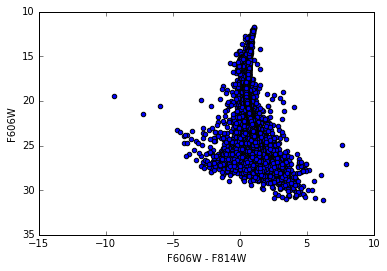

In [43]:
### now let's plot
plt.scatter(color, f606w)
plt.gca().invert_yaxis()
plt.xlabel('F606W - F814W')
plt.ylabel('F606W')
plt.show()